# Installing Requirements
In this section, with a file named "requirements.txt", we're checking to see if all needed packages are installed, if not, force "pip install" them.

It's assumed "requirements.txt" has the following format:
- Every line refers to 1 library

If there's any doubt regarding the format of said file, use the following as an example:
```
tqdm
numpy 
pandas 
seaborn 
```

In [271]:
import importlib.util
import sys


with open('requirements.txt', 'r') as f:
    for dependency in f.readline():
        dependency = dependency.replace('\n', '')
        # If installed OR not found, continue
        if (dependency in sys.modules )or ((spec := importlib.util.find_spec(dependency)) is None): continue

        module = importlib.util.module_from_spec(spec)
        sys.modules[dependency] = module
        spec.loader.exec_module(module)


# Importing necessary packages

In [272]:
import time
import datetime as dt

import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import meteostat as ms
import lightgbm as lgb
import matplotlib.pyplot as plt

from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from kneed import KneeLocator

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from yellowbrick.cluster import SilhouetteVisualizer


from hyperopt import fmin
from hyperopt import STATUS_OK
from scipy.stats import zscore
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split



pd.options.mode.chained_assignment = None   # to not warn when "A value is trying to be set on a copy of a slice from a DataFrame."

# Assignment Tasks

## Task 1: Data Understanding and Preparation
Task: This task involves summarizing and visualizing the data to provide valuable insights. Consider questions that could be interesting to check with the available data and provide answers using textual summaries or data visualization. Based on this analysis, you should also check if it is necessary to carry out any data clean-up and pre-processing steps.

In the next code section, it is assumed there're two files: `fires_test.csv` and `fires_train.csv` in the "mother" folder of this notebook, so as follows:

``` 
folder
├──fires_test.csv
├──fires_train.csv
├──notebook
│  ├──notebook.ipynb **this file**
│  └──requirements.txt
│ ...
```

### Reading training and testing files

We're going to utilize the package `pandas` and read the `csv` files as a `pandas.DataFrame` object and we'll utilize some methods and properties of the `pandas.DataFrame` object in order to understand, treat and prepare the data.

In [273]:
# read train data
df = pd.read_csv("..\\fires_train.csv")
df_test = pd.read_csv("..\\fires_test.csv")

### Data Understanding
Prior to data treatment, we need to have a good grasp on the data we're dealing with.

To do so, we're going to make use of some python packages, such as: `seaborn`, `pandas` and `matplotlib`.

The data analysis will go as follows:
* Plotting all the pair of vairables in a scatterplot in order to understand how the data correlates with each other
* Describing the data with the `pandas.DataFrame.describe` method in order to get a better gasp of what each variable represents
* Plotting the correlation matrix between all the variables in order to check for some redundancy between variables
* Plotting a histogram of each of the variable to grasp if the variables match any distribution or have some other pattern

Pairplot between the variables

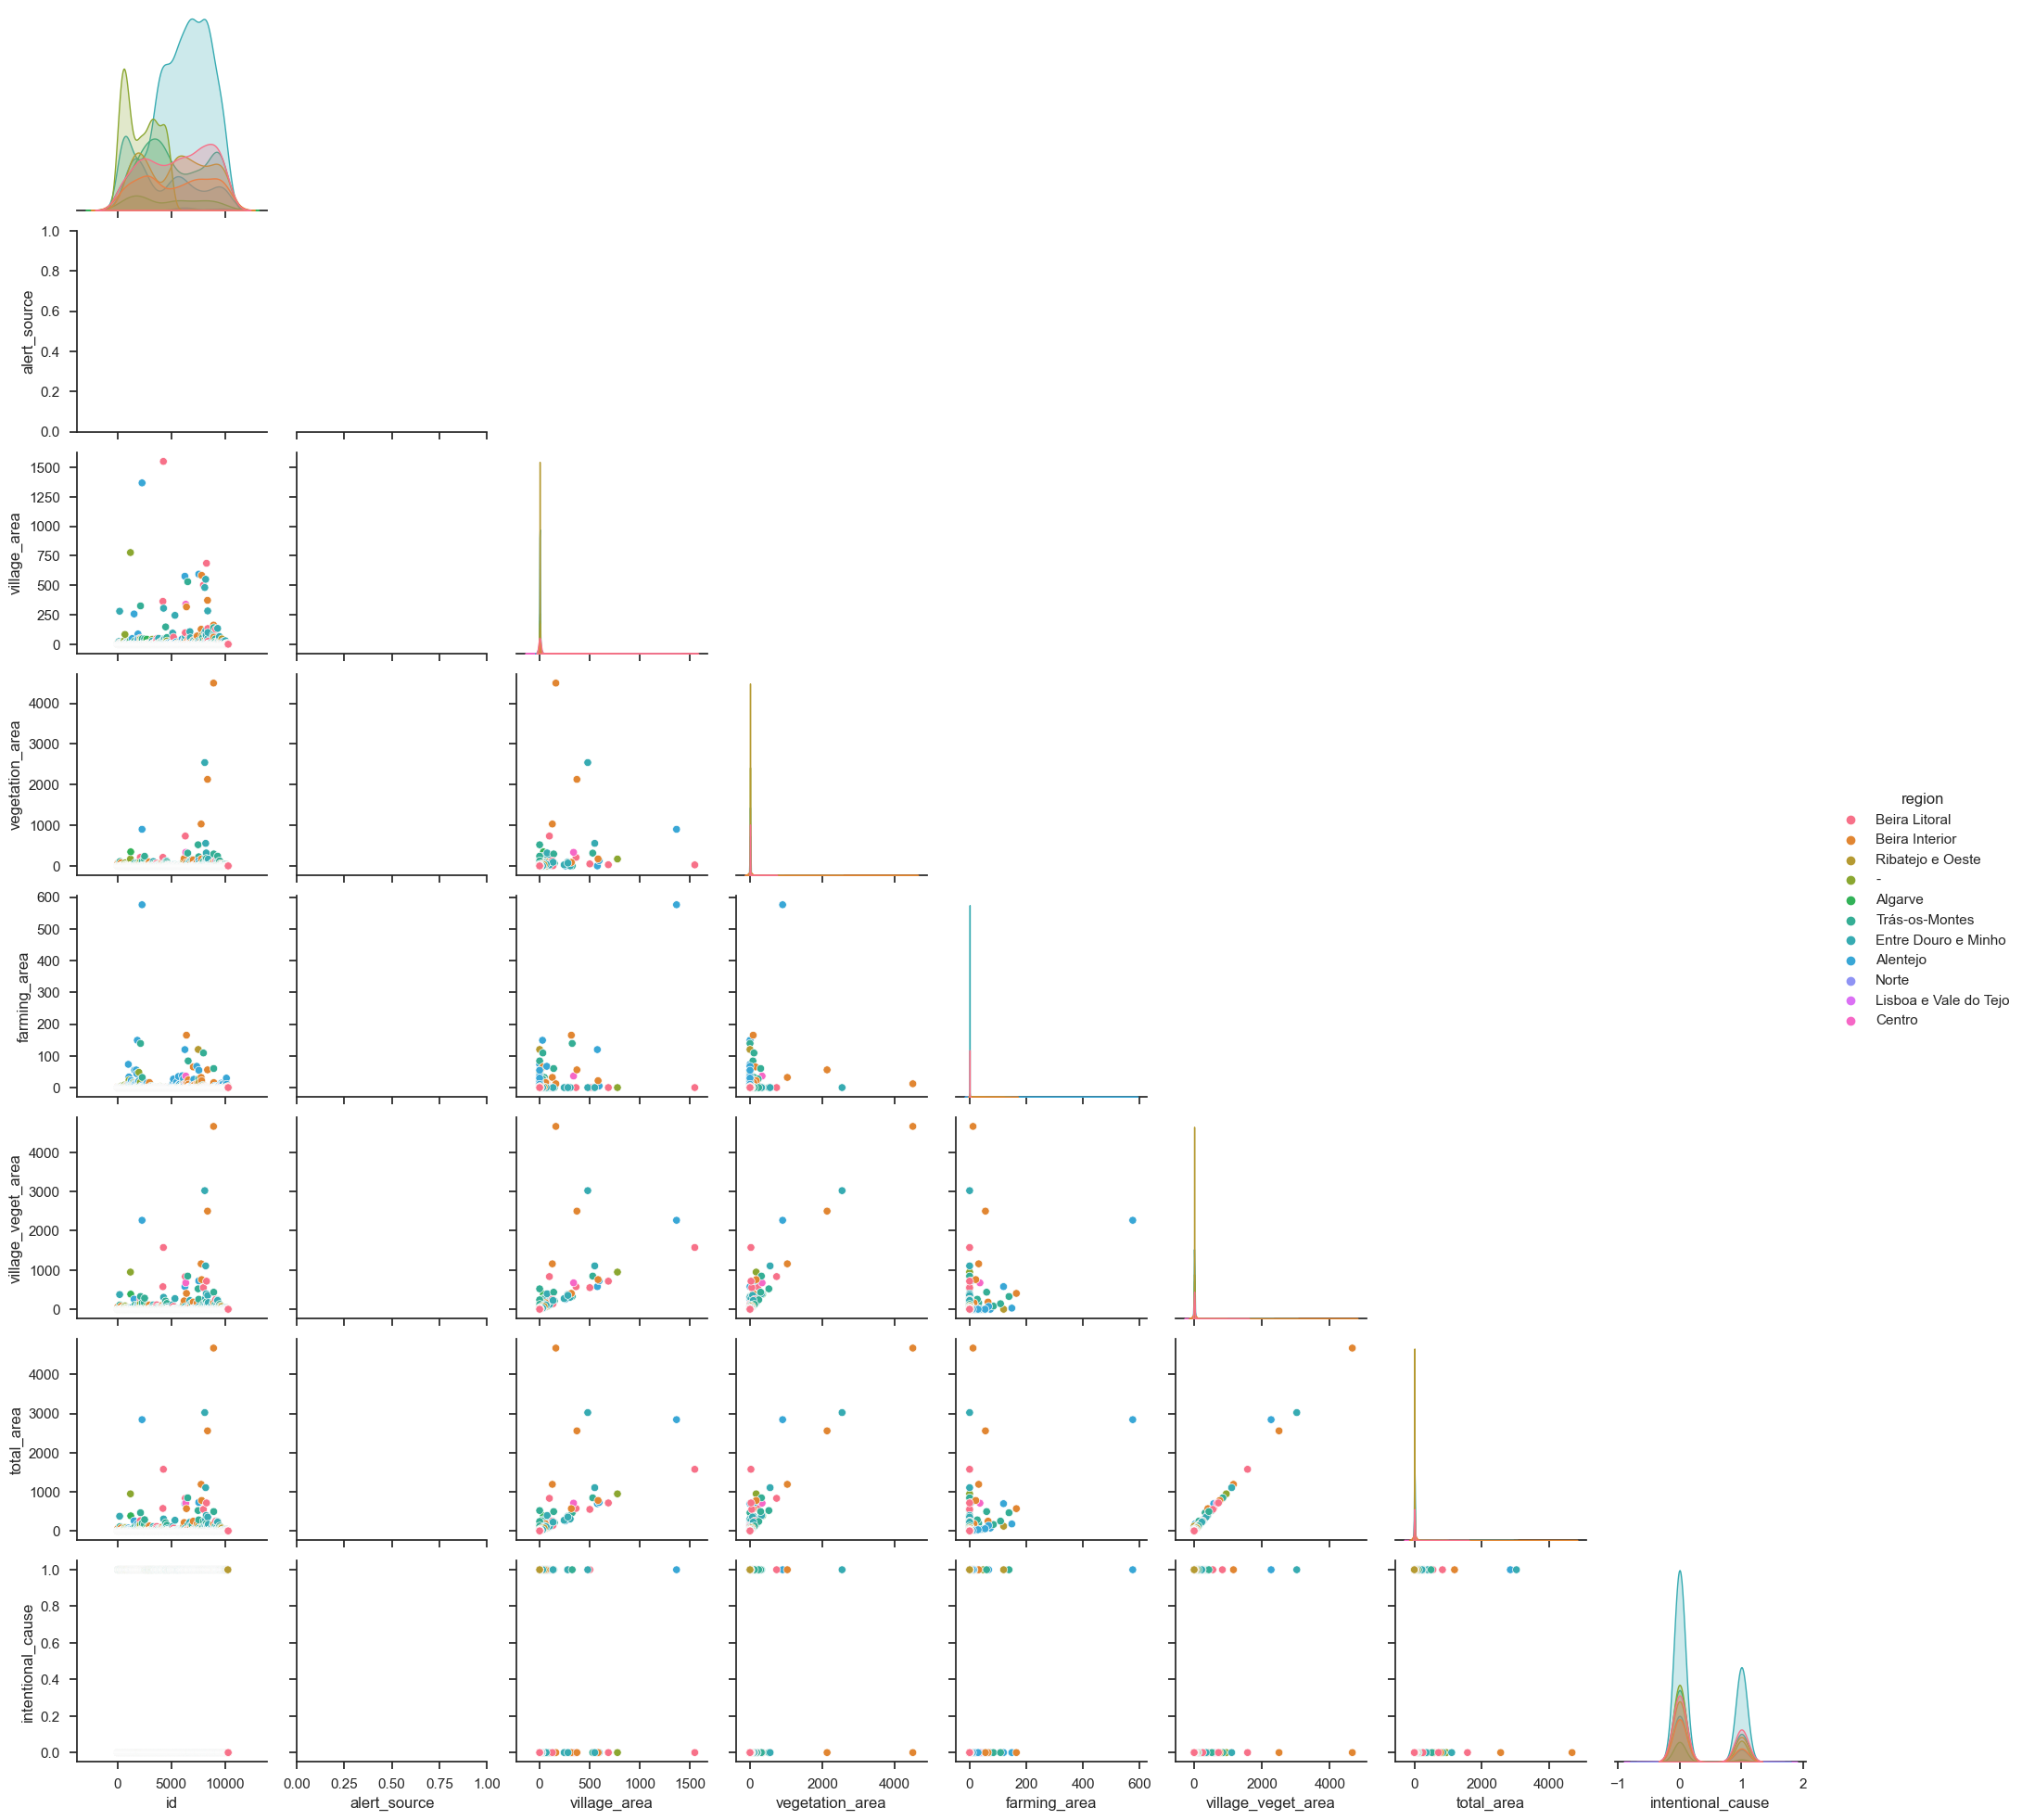

In [274]:
# pairplot (takes a lot of time)
sns.set_theme(style="ticks")
sns.pairplot(df, hue="region", corner=True)

Description of the data

In [275]:
df.describe()

,id,alert_source,village_area,vegetation_area,farming_area,village_veget_area,total_area,intentional_cause
count,10309.000000,0.0,10309.000000,10309.000000,10309.000000,10309.000000,10309.000000,10309.000000
mean,5155.000000,NaN,1.873137,2.931693,0.386639,4.804830,5.191468,0.283248
std,2976.096297,NaN,29.120729,58.902921,6.995677,73.459388,76.175106,0.450598
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2578.000000,NaN,0.000000,0.000000,0.000000,0.001000,0.016000,0.000000
50%,5155.000000,NaN,0.000000,0.010000,0.000000,0.050000,0.100000,0.000000
75%,7732.000000,NaN,0.011600,0.200000,0.000000,0.500000,0.700000,1.000000
max,10309.000000,NaN,1548.920000,4499.000000,576.000000,4661.000000,4673.000000,1.000000


Variables Correlation

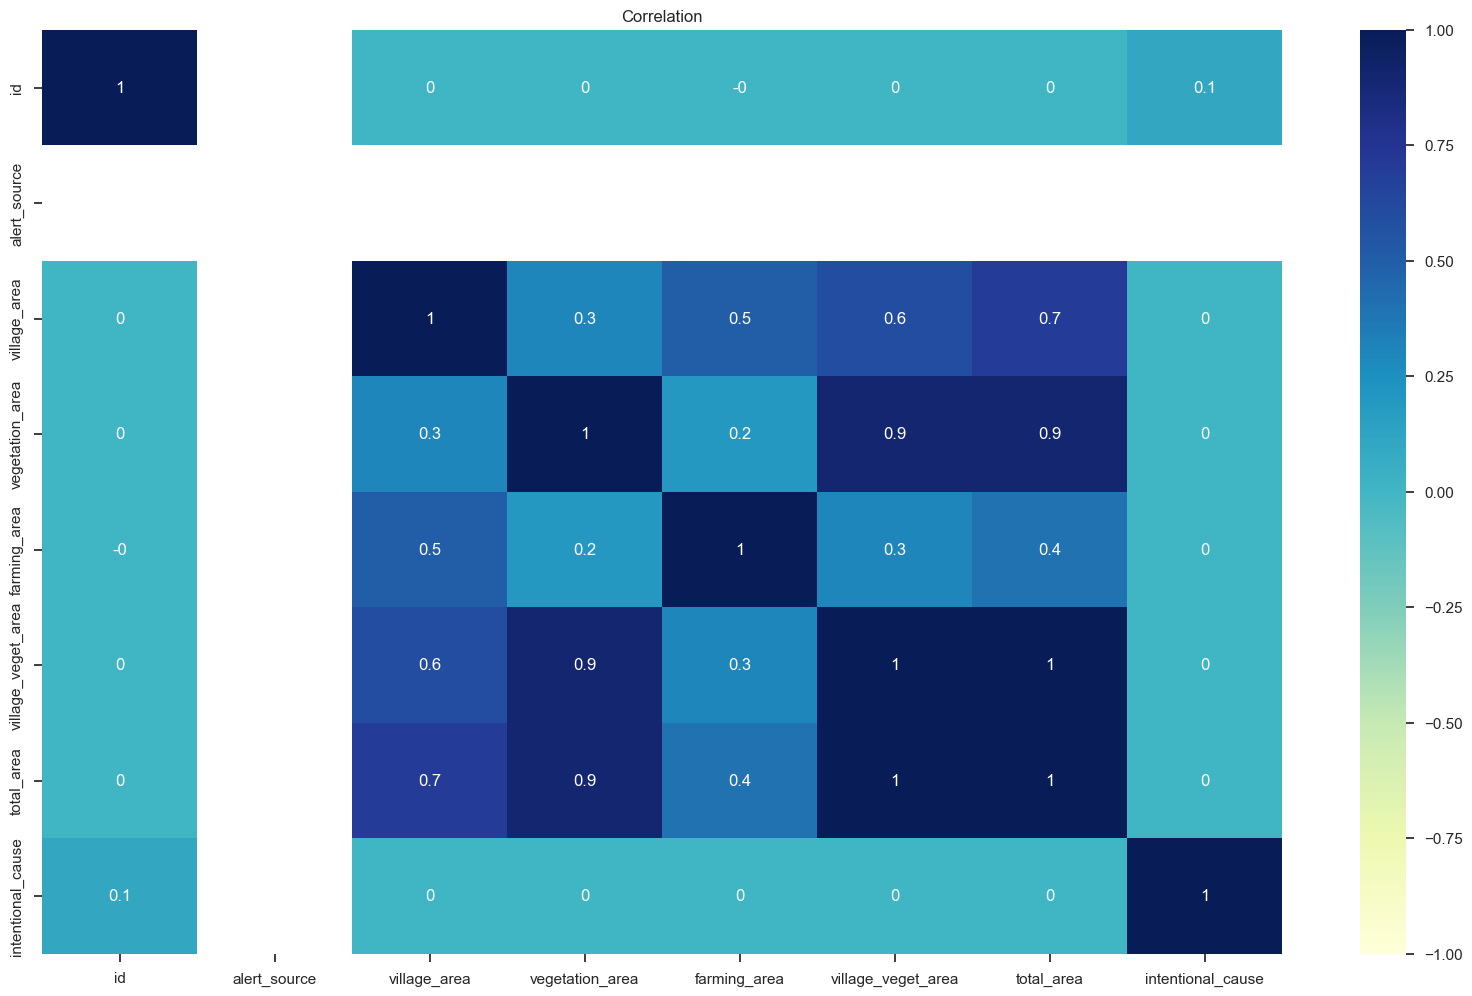

In [276]:
plt.figure(figsize=(20, 12))                     
plt.title('Correlation')
matrix = sns.heatmap(df.corr().round(1), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

Distribution of each variable

array([[<AxesSubplot: title={'center': 'id'}>,
        <AxesSubplot: title={'center': 'alert_source'}>,
        <AxesSubplot: title={'center': 'village_area'}>],
       [<AxesSubplot: title={'center': 'vegetation_area'}>,
        <AxesSubplot: title={'center': 'farming_area'}>,
        <AxesSubplot: title={'center': 'village_veget_area'}>],
       [<AxesSubplot: title={'center': 'total_area'}>,
        <AxesSubplot: title={'center': 'intentional_cause'}>,
        <AxesSubplot: >]], dtype=object)

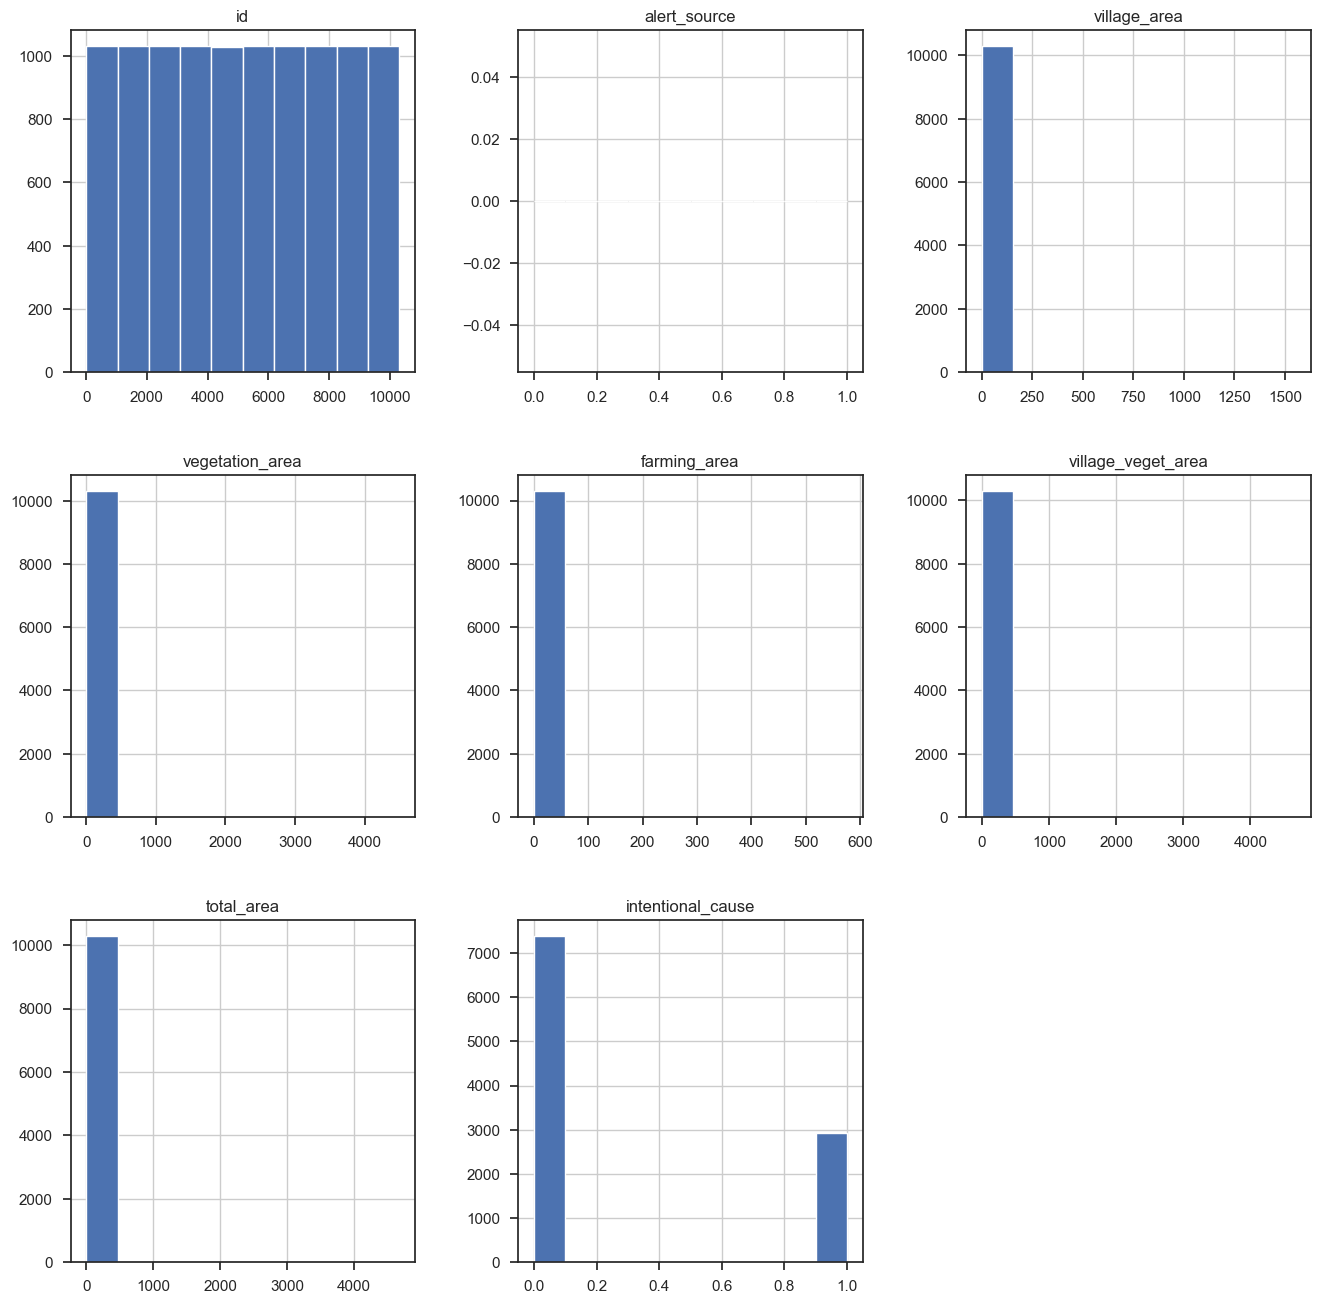

In [277]:
fig = plt.figure(figsize = (16,16))
ax = fig.gca()
df.hist(ax = ax)

### Data Preparation

After having explored the dataset, we noticed some data treatment which should improve our modeling by the end.

In this section, we explore some data treatment and engineering in order to better model our problem

#### Converting Date columns to datetime type

Since we deal with some `date` columns, in this section we change the already existing date columns to the `datetime.datetime` object and we merge the `date` and `hour` columns into one column only, for easier treatment later on.

In [278]:
def convert_date_cols(df):
    # converting "Date" columns to datetime type
    for col in df.columns:
        if 'date' not in col.lower(): continue

        # Converting date column to datetime
        df[col] = pd.to_datetime(df[col])
        # Converting HOUR column (related to date column) to datetime
        hour_col = col.replace('_date', '_hour')
        df[hour_col] = pd.to_datetime(df[hour_col], format='%H:%M:%S')

        # Create a "merged" date column containing both date and hour
        df[col] = pd.to_datetime(df[col].dt.strftime('%Y/%m/%d ') + df[hour_col].dt.strftime('%H:%M:%S'), format='%Y/%m/%d %H:%M:%S')

        # Converting "HOUR" column to string "HH:MM" format
        df[hour_col] = df[hour_col].dt.strftime('%H:%M')
    return df

In [279]:
# Running function on all dataframes
df = convert_date_cols(df)
df_test = convert_date_cols(df_test)

#### Creating new columns with different meanings

DayOfWeek + periodOfDay + monthAlert

In [280]:
def create_dates_columns(df):
    # drop columns
    df.drop(columns=['region', 'alert_source', 'total_area'], inplace=True) 

    # day of the week
    df['dayOfWeekFire']=df['alert_date'].dt.dayofweek

    # period of the day
    df['periodOfDay'] = pd.cut(df.alert_date.dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=[0, 1, 2, 3],
    right=False,
    include_lowest=True).astype('int')

    # month of alert
    df['monthAlert']=df['alert_date'].dt.month
    return df

In [281]:
# Running function on all dataframes
df = create_dates_columns(df)
df_test = create_dates_columns(df_test)

Difference between Alert and First Intervention Date + Difference between Alert date and Extinction Date

In [282]:
def create_diff_between_dates(df, dropna=True):
    # drop null rows to avoid error on combining
    if dropna:
        df = df.dropna(subset=['extinction_date', 'firstInterv_date', 'firstInterv_hour', 'alert_date', 'alert_hour'])

    # # combine dates and times
    # df['alertD'] = pd.to_datetime(df["alert_date"].astype(str) + " " + df["alert_hour"].astype(str))
    # df['excD'] = pd.to_datetime(df["extinction_date"].astype(str) + " " + df["extinction_hour"].astype(str))
    # df['intD'] = pd.to_datetime(df["firstInterv_date"].astype(str) + " " + df["firstInterv_hour"].astype(str))

    # diff between alert, first intervention, extinction (drop rows to avoid error)
    df['diffIntAlert'] = None
    df.loc[~df['firstInterv_date'].isnull(), 'diffIntAlert'] = ((df['firstInterv_date'].fillna(dt.datetime(1900, 1, 1)) - df['alert_date'].fillna(dt.datetime(1900, 1, 1))).dt.total_seconds()).astype('int')
    
    df['diffExcAlert'] = None
    df.loc[~df['extinction_date'].isnull(), 'diffExcAlert'] = ((df['extinction_date'].fillna(dt.datetime(1900, 1, 1)) - df['alert_date'].fillna(dt.datetime(1900, 1, 1))).dt.total_seconds()).astype('int')
    
    df['diffIntAlert'] = df['diffIntAlert'].astype(float)
    df['diffExcAlert'] = df['diffExcAlert'].astype(float)
    return df

In [283]:
# Running function on all dataframes
df = create_diff_between_dates(df)
df_test = create_diff_between_dates(df_test)

#### Fixing Latitude and Longitude Values

Some coordinates are not in the correct form, here we're correcting them

In [284]:
# Corrigir Latitude e Longitude
def fixing_coords_to_decimal(value):
    if '-' in value: value = value.split(" ")[-1]
    value = value.replace(',', '.').replace("''", "")
    if ':' in value:
        aux = value.split(":") 
    else:
        aux = value.split('º')
        aux = aux[:1] + aux[-1].split("'")
    aux = [float(x) for x in aux]
    if len(aux) < 3: return None
    return aux[0] + (aux[1]+ aux[2]/60)/60
    
def fix_lat_lon(df):
    for col in ['lat', 'lon']: df[col] = df[col].apply(fixing_coords_to_decimal)
    df['lon'] = -df['lon']    # Longitude is negative in portugal
    return df

In [285]:
# Running function on all dataframes
df = fix_lat_lon(df)
df_test = fix_lat_lon(df_test)

#### Obtaining Temperature data

Here we're obtaining all the stations in Portugal

In [286]:
# Function which calculates distances
def distance_coords(coord1, coord2):
    (lat1, lon1) = coord1
    (lat2, lon2) = coord2
    dist = np.degrees(np.arccos(np.sin(np.radians(lat1))*np.sin(np.radians(lat2)) + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.cos(np.radians(lon1-lon2))))
    return dist*90*1.1515*1609.344

# Variable to check how long it takes
start_time = time.time()

# Normalize alert_date (to fetch temperature for a given day, not hour/minute/second)
df['alert_date'] = df['alert_date'].copy().dt.normalize()
df_test['alert_date'] = df_test['alert_date'].copy().dt.normalize()

# Getting list of all stations  available
stations = ms.Stations().fetch()
stations = stations[stations['country']=='PT']  # Filtering to portuguese stations

Obtaining temperature for (some of) the stations, and filtering our station set to only those with data

In [287]:
print(f"<{time.time()-start_time:.2f} sec> :: Getting temps")
# Fetching all available data between the dates we need (daily)
temps = ms.Daily(loc=stations, start=min(df['alert_date'].min(), df_test['alert_date'].min()), end=max(df['extinction_date'].max(), df_test['extinction_date'].max())).fetch().reset_index()

# Filtering stations to stations with "Temperature" data
stations = stations.reset_index().drop(columns=['daily_start', 'daily_end'])    # Dropping columns since we're going to get these dates from "temps"
stations = stations[stations['id'].isin(temps['station'])]

<0.07 sec> :: Getting temps


Fixing stations "daily_start" and "daily_end" columns to match our "temps" dataframe

In [288]:
# Updating "stations" "daily_start" and "daily_end"
temps['time_max'] = temps['time']
stations = stations.merge(temps.groupby(by=['station'], as_index=False).agg({'time': 'min', 'time_max': 'max'}), left_on='id', right_on='station').rename(columns={'time': 'daily_start', 'time_max': 'daily_end'})


# Creating new "coords" column to calculate distances
stations['coords'] = stations.apply(lambda x: (x['latitude'], x['longitude']), axis=1)

Adding temperatures to dataframe

In [289]:
def fetch_temperature(df):
    df['coords'] = df.apply(lambda x: (x['lat'], x['lon']), axis=1)
    
    pbar = tqdm.tqdm(total=df.shape[0], position=0, desc="Obtaining temperatures")

    # Function which returns temperature for a given row in "df" DataFrame or "test" DataFrame (it requires a column of "coords")
    # [Defined here in order to get 2 distinct ProgressBars]
    def get_temp(row):
        # Calculates distances of each station to this row
        stations['distance'] = stations['coords'].apply(lambda x: distance_coords(x, row['coords']))

        # Filtering stations to timeperiod of our "row"
        station = stations[ (stations['daily_start'] <=  row['alert_date']) & (stations['daily_end'] >=  row['alert_date'])]

        # Iterating through every 
        for i in range(station.shape[0]):
            station_ = station.sort_values(by=['distance'], ascending=True).iloc[i]
            df = temps[ (temps['station'] == station_['id']) & (temps['time'] == row['alert_date']) ]
            if df.size == 0: continue
            df['distance_to_station'] = station_['distance']
            pbar.update(1)
            return df
        raise ValueError("No Temperature found")

    # Adding temperatures to our original dataframe
    df['temp'] = df.apply(get_temp, axis=1)
    df['distance_to_station'] = df['temp'].apply(lambda x: x['distance_to_station'].iloc[0] if x.size>0 else -1)
    df['avg_temperature']     = df['temp'].apply(lambda x: x['tavg'].iloc[0]).round()
    df['max_temperature']     = df['temp'].apply(lambda x: x['tmax'].iloc[0]).round()
    return df

In [290]:
# Running function on all dataframes
df = fetch_temperature(df)
df_test = fetch_temperature(df_test)

df_descriptive_modeling = df.copy()   # Storing variable for later on (descriptive modeling)

Obtaining temperatures: 100%|██████████| 4283/4283 [00:11<00:00, 359.67it/s]


#### Data Encoding 

Since some of the models we're going to be using don't accept a `string` as input, we'll have to encode some of the columns such as `district`/`municipality`/etc with a number which represents each of the different values.

**NOTE**: It can be noted we don't encode the columns `municipality` and `parish`. That's because the data in the testing dataset contains values which are not present in the training dataset, so we decided to only keep the variables which all unique values are present on both the training and testing dataset.

In [291]:
# encode strings
cols = ['district', 'origin']
df[[col +  '_encoded' for col in cols]] = df[cols].apply(LabelEncoder().fit_transform)
false_alarm_encoded = df[df['origin'] == 'false_alarm'].iloc[0]['origin_encoded']

for col in cols:
    encoding = df[[col, f'{col}_encoded']].drop_duplicates()
    df_test = df_test.merge(encoding, on=[col], how='left')
    df[col] = df[f'{col}_encoded']
    df.drop(columns = f'{col}_encoded', inplace=True)
    
    df_test [col] = df_test [f'{col}_encoded']
    df_test .drop(columns = f'{col}_encoded', inplace=True)

#### Filtering the data

Now that we've encoded the columns we're interested in and we've created all the wanted columns, we ignore any other column rather than the `numeric` ones to be able to train the models

In [292]:
# get only numeric columns and move predicto to last
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df_test = df_test.select_dtypes(include=numerics)

cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('intentional_cause')) #Remove b from list

df = df[cols+['intentional_cause']] #Create new dataframe with columns in the order you want
df_test = df_test[cols] #Create new dataframe with columns in the order you want

## Task 2: Predictive Modelling
Task: From the available data, you should define the data set used for the classification task at hand. Different models should be considered, and the choice of the final model should be justified. 

### Extreme Gradient Boosting (XGBoost)

#### XGBoost hyperparameter search

In this section we're are looking for the best parameters to include in our XGBoost model

In [293]:
# hyperparameter space variables
space={'max_depth': hp.quniform("max_depth", 3, 35, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 30,
        'seed': 123
    }


# Defining training and testing sets
train = df.loc[[x for x in df.index if np.random.random()<0.7]].copy()
test  = df.loc[~df.index.isin(train.index)].copy()


# search function for hyperparameter
def objective(space):
    clf=xgb.XGBRegressor(objective ='reg:logistic', booster='gbtree',
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), eval_metric="auc", early_stopping_rounds=10)
    
    evaluation = [(train[cols], train['intentional_cause']), (test[cols], test['intentional_cause'])]
    
    clf.fit(train[cols], train['intentional_cause'],
            eval_set=evaluation, verbose=0)
    

    pred = clf.predict(test[cols])
    accuracy = accuracy_score(test['intentional_cause'], pred>0.5)
    # print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# run hyperparameter function
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# show results
print("The best hyperparameters are : ")
print(best_hyperparams)

100%|██████████| 100/100 [00:08<00:00, 12.46trial/s, best loss: -0.7510053619302949]
The best hyperparameters are : 
{'colsample_bytree': 0.4247294918994495, 'gamma': 3.0983640510879487, 'max_depth': 15.0, 'min_child_weight': 1.0, 'reg_alpha': 1.0, 'reg_lambda': 0.057789931298920544}


#### XGBoost Model

In this section, we're going to make use of the `xgboost` python package which contains a `XGBRegressor` class which allows for the modeling of a *XGBoost* model

In [294]:
XGBoostModel = xgb.XGBRegressor(
    objective ='reg:logistic'
    ,colsample_bytree = 0.3
    ,learning_rate = 0.2
    ,max_depth = 28
    ,n_estimators = 30
    ,min_split_loss=5
    ,booster='gbtree'
)

### Support Vector Machine Model

In [295]:
SVMModel = SVC(kernel='linear', verbose=0)

### Light Gradient-Boosting Machine Model

In [335]:
LGBMModel = lgb.LGBMRegressor(
    boosting_type='dart', objective='binary', class_weight=None, colsample_bytree=1.0,
    importance_type='split', learning_rate=0.1, max_depth=-1, min_child_samples=20, 
    min_child_weight=0.001, min_split_gain=0.0,n_estimators=100, n_jobs=-1, 
    num_leaves=50, random_state=None, reg_alpha=0.0,reg_lambda=0.0, verbose=0, 
    subsample=1.0, subsample_for_bin=200000, subsample_freq=0, force_col_wise=True
)

### Linear Regression Model

In [297]:
linear_regression = LinearRegression()

### Evaluation

#### Evaluation Class
In order to compare all our different models, we decided to create a class which, given a certan model and dataset, will evaluate the given method with some different methods. Afterwards we'll apply this class to all the model defined previously and compare them between each other

The methods included:
* Holdout Method
* Random SubSampling
* Startified K Folding
* Leave One Out Cross Validation
* ROC + AUC score
* Confusion Matrix

**NOTE**: Despiting `Leave_One_Out_Cross_Validation` being implemented, it might not be ran since it is very complex to run and it took +/- 8 hours to run. We decided to exclude it in the method `run_all_evaluations` by default for its complexity and for not affecting the results by our tests

In [345]:
class EvalModel:
    def __init__(self, model=None, model_name='', dataset: pd.DataFrame=None, prediction_attrs=None):
        self.model = model
        self.label = model_name
        self.df = dataset.copy()

        if not isinstance(prediction_attrs, list): prediction_attrs=[prediction_attrs]
        self.pred_attrs=prediction_attrs

    # Evaluation metrics
    def _mean_prediction_error(self, real, pred):
        return np.average(pred-real)

    def _standard_error(self, real, pred):
        return np.std(pred-real)


    # Evaluation
    def evaluate(self, print_evaluation=True):
        test = self.test if not isinstance(self.train, list) else self.test[-1]

        self.real = test[self.pred_attrs]
        self.pred = self.model.predict(test.drop(columns=self.pred_attrs)) 
        
        if len(self.pred_attrs) == 1:
            self.real = self.real.to_numpy().T[0]

        self.std_err = self._standard_error(self.real, self.pred)
        self.avg_err = self._mean_prediction_error(self.real, self.pred)
        
        
        if print_evaluation: print(f'<{self.label}> {self.method} Error: {self.avg_err:.3f} +/- {self.std_err:.3f}')
        return self.avg_err

    # Fitting model
    def fit(self):
        if isinstance(self.train, list):
            return self.model.fit(self.train[-1].drop(columns=self.pred_attrs), self.train[-1][self.pred_attrs])
        return self.model.fit(self.train.drop(columns=self.pred_attrs), self.train[self.pred_attrs])


    # Defining evaluation methods
    def Houldout_Method(self, train_ratio=0.7, print_evaluation=True, **kwargs):
        self.method = 'Holdout Method'
        self.train  = self.df.iloc[:int(self.df.shape[0]*train_ratio)].copy()
        self.test   = self.df.loc[~self.df.index.isin(self.train.index)].copy()

        self.fit()
        self.evaluate(print_evaluation=print_evaluation)

        
    def Random_Subsampling(self, seed=1, val_ratio=0.7, print_evaluation=True):
        np.random.seed=seed
        self.method = 'Random SubSampling'

        self.train = self.df.loc[[x for x in self.df.index if np.random.random()<val_ratio]].copy()
        self.test  = self.df.loc[~self.df.index.isin(self.train.index)].copy()

        self.fit()
        self.evaluate(print_evaluation=print_evaluation)
        


    def Stratified_K_Fold(self, seed=1, n_splits=10, print_folds=True, print_evaluation=True):
        np.random.seed=seed
        self.method='k-fold Cross Validation'

        # pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth))
        strtfdKFold = StratifiedKFold(n_splits=n_splits)

        kfold = strtfdKFold.split(self.df.drop(columns=self.pred_attrs), self.df[self.pred_attrs])
        scores = []

        self.train = []
        self.test = []
        for k, (train, test) in enumerate(kfold):
            self.train.append(self.df.iloc[train])
            self.test.append(self.df.iloc[test])

            self.fit()
            
            score = self.evaluate(print_evaluation=False)
            scores.append(score)
            if print_folds: print(f'Fold: {k+1:2d}, Training/Test Split Distribution: {np.bincount(self.df[self.pred_attrs].iloc[test].to_numpy().T[0])}, Error: {score:.3f}')

        self.avg_err = np.mean(scores)
        self.std_err = np.std(scores)
        if print_evaluation: print(f'<{self.label}> {self.method} Error: {self.avg_err:.3f} +/- {self.std_err:.3f}')
        
    def Leave_One_Out_Cross_Validation(self, print_folds=True, print_evaluation=True, **kwargs):
        self.method='Leave One Out Cross Validation'
        
        leaveOneOut = LeaveOneOut()
        kfold = leaveOneOut.split(self.df.drop(columns=self.pred_attrs), self.df[self.pred_attrs])
        scores = []
        
        self.train = []
        self.test = []
        for k, (train, test) in enumerate(kfold):
            self.train.append(self.df.iloc[train])
            self.test.append(self.df.iloc[test])

            self.fit()
            
            score = self.evaluate(print_evaluation=False)
            scores.append(score)
            if print_folds: print(f'Fold: {k+1:2d}, Training/Test Split Distribution: {np.bincount(self.df[self.pred_attrs].iloc[test].to_numpy().T[0])}, Error: {score:.3f}')

        self.avg_err = np.mean(scores)
        self.std_err = np.std(scores)
        if print_evaluation: print(f'<{self.label}> {self.method} Error: {self.avg_err:.3f} +/- {self.std_err:.3f}')

    def Bootstrap_Method(self, n_tries=200, print_evaluation=True, **kwargs):
        scores = []
        for _ in range(n_tries):
            self.Random_Subsampling(print_evaluation=False, **kwargs)
            
            
            scores.append(self.evaluate(print_evaluation=False))
        self.evaluate(print_evaluation=print_evaluation)
        self.method = 'Bootstrap Method'
    
    def ROC(self, figsize=(8, 6), metric_index_to_compare=0, print_auc_score=True):
        
        self.Random_Subsampling(print_evaluation=False)

        self.real = self.test[self.pred_attrs[metric_index_to_compare]].to_numpy().T
        self.pred = self.model.predict(self.test.drop(columns=self.pred_attrs))
        # ROC Curve
        self.roc_curve = roc_curve(self.real, self.pred)
        self.false_positive_rate = self.roc_curve[0]
        self.true_positive_rate = self.roc_curve[1]
        self.threshholds = self.roc_curve[2]
        
        self.roc_auc_score = roc_auc_score(self.real, self.pred)
        if print_auc_score: print(f'<{self.label}> ROC AUC score: {self.roc_auc_score:.3f}')
        
        plt.figure(figsize=figsize)
        ax = plt.gca()
        ax.plot(self.false_positive_rate, self.true_positive_rate)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve <{self.label}>')
        plt.show()

    def conf_matrix(self, metric_index_to_compare=0, figsize=(6, 6)):
        class_names = np.array([0, 1])

        # Train and divide into test and train
        self.Random_Subsampling(print_evaluation=False)

        # Real and Predicted values of test set
        self.real = self.test[self.pred_attrs[metric_index_to_compare]].to_numpy().T
        self.pred = np.vectorize(lambda x: min(x, 1))(self.model.predict(self.test.drop(columns=self.pred_attrs)).round())

        matrix = confusion_matrix(self.real, self.pred)
        plt.figure(figsize=figsize)
        sns.set(font_scale=1)
        sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2, fmt='g')

        # Add labels to the plot
        tick_marks = class_names
        tick_marks2 = tick_marks + 0.5
        plt.xticks(tick_marks + 0.5, class_names, rotation=0)
        plt.yticks(tick_marks2, class_names, rotation=0)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    
    def run_all_evaluations(self, leave_one_out=False, stratified_splits=10):
        self.Houldout_Method()
        self.Random_Subsampling()
        self.Stratified_K_Fold(print_folds=False, n_splits=stratified_splits)
        if leave_one_out: self.Leave_One_Out_Cross_Validation(print_folds=False)
        self.ROC()
        self.conf_matrix()

#### Evaluating models

##################################################
#              Evaluating <XGBoost>              #
##################################################
<XGBoost> Holdout Method Error: 0.014 +/- 0.433
<XGBoost> Random SubSampling Error: -0.004 +/- 0.384
<XGBoost> k-fold Cross Validation Error: 0.173 +/- 0.171
<XGBoost> ROC AUC score: 0.832


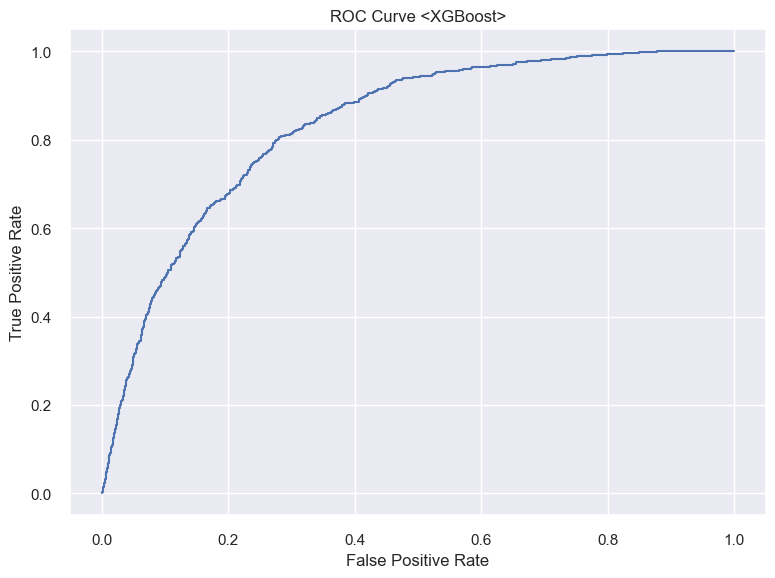

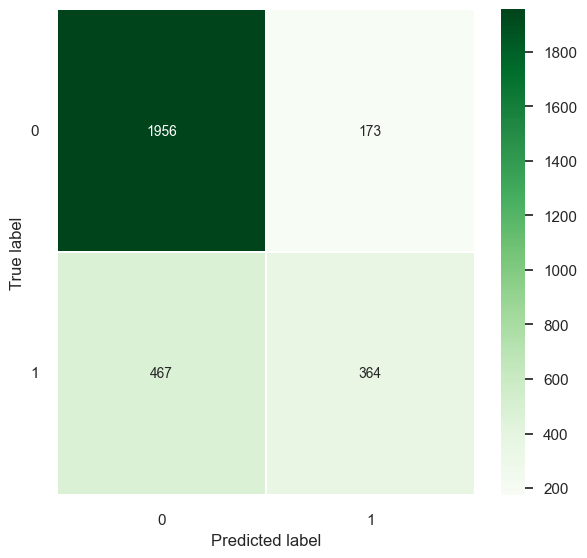

##################################################
                 Evaluating <SVM>                 
##################################################
##################################################
                Evaluating <LGBM>                 
##################################################
<LGBM> Holdout Method Error: 0.008 +/- 0.427
<LGBM> Random SubSampling Error: 0.004 +/- 0.386
<LGBM> k-fold Cross Validation Error: 0.169 +/- 0.168
<LGBM> ROC AUC score: 0.834


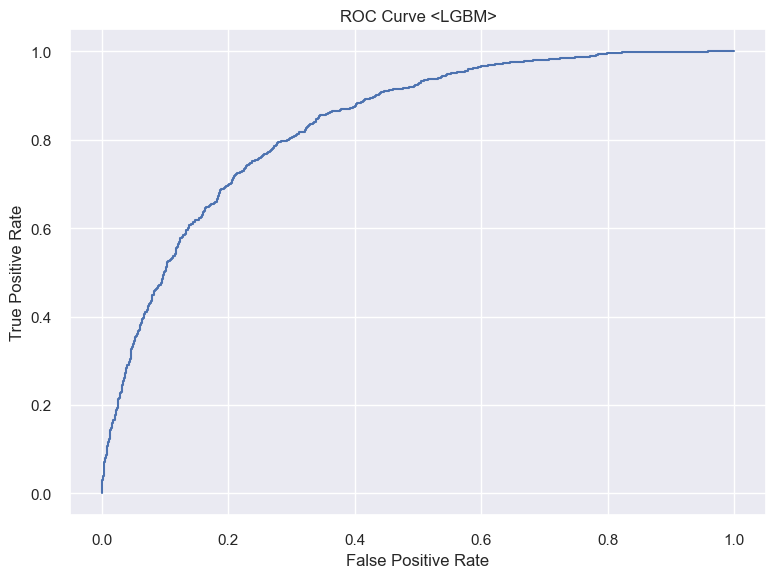

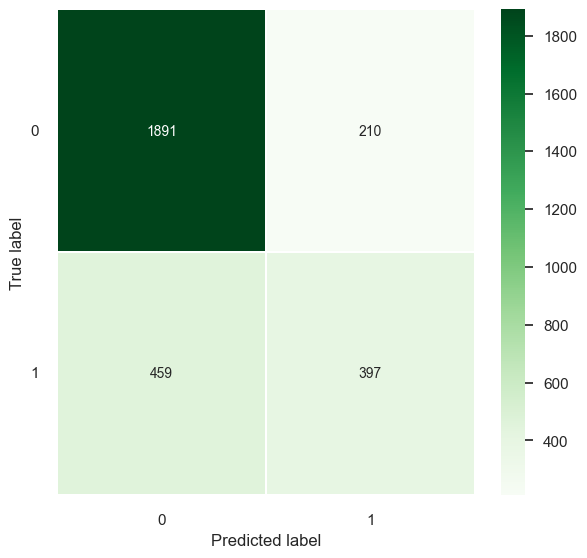

##################################################
          Evaluating <Linear Regression>          
##################################################
<Linear Regression> Holdout Method Error: -0.022 +/- 0.806
<Linear Regression> Random SubSampling Error: 0.012 +/- 0.459
<Linear Regression> k-fold Cross Validation Error: 0.007 +/- 0.084
<Linear Regression> ROC AUC score: 0.660


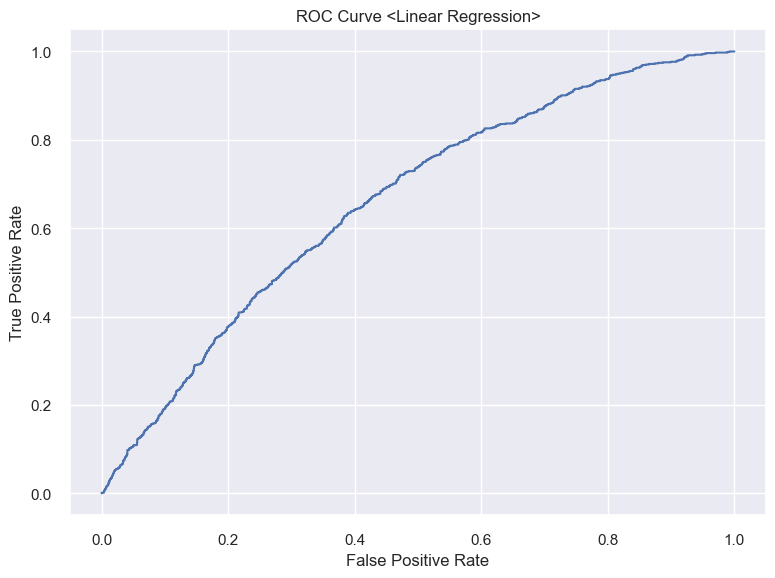

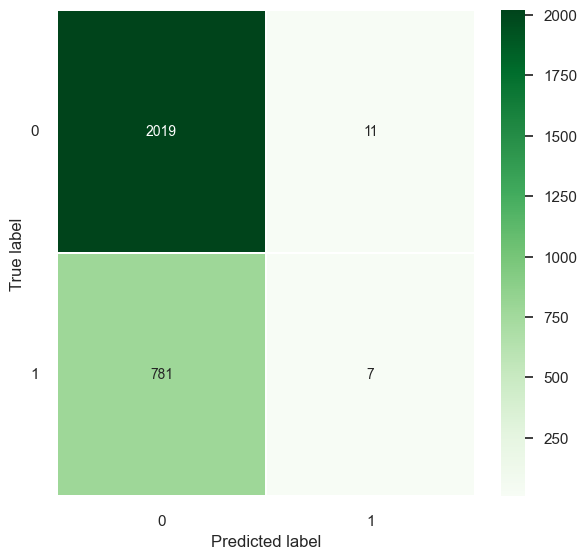

In [347]:
print(f'{"#":#^50s}\n#{"Evaluating <XGBoost>":^48s}#\n{"#":#^50s}')
xgboost_eval = EvalModel(XGBoostModel, model_name='XGBoost', dataset=df, prediction_attrs='intentional_cause')
xgboost_eval.run_all_evaluations()

print(f'{"#":#^50s}\n{"Evaluating <SVM>":^50s}\n{"#":#^50s}')
df_svm = df.copy().dropna(how='any', axis=0).iloc[:1000]    # We need to drop nulls since SVM doesn't work with "NA" values [only first 1000 values to check it fast, since we tried running it for more than 12h with all the data]
svm_eval = EvalModel(SVMModel, model_name='SVM', dataset=df_svm, prediction_attrs='intentional_cause')    
# svm_eval.ROC()  # We only run  the ROC model since it takes a while to compile this specific model. We chose not to select it

print(f'{"#":#^50s}\n{"Evaluating <LGBM>":^50s}\n{"#":#^50s}')
lgbm_eval = EvalModel(LGBMModel, model_name='LGBM', dataset=df, prediction_attrs='intentional_cause')
lgbm_eval.run_all_evaluations()

print(f'{"#":#^50s}\n{"Evaluating <Linear Regression>":^50s}\n{"#":#^50s}')
regr_eval = EvalModel(linear_regression, model_name='Linear Regression', dataset=df.dropna(), prediction_attrs='intentional_cause')
regr_eval.run_all_evaluations()

## Task 3: Kaggle Competition
Task: Additionally, you should submit your solution for the fires_test.csv data set to the Kaggle Competition. Your rank will be accounted for in the final grade. 

### Using best model to run on the total Training dataset

After having ran the evaluation test in all the models, we decided to go with `LGBM` model to address our problem.

With that in mind, the next section uses `LGBM` model to train with the entire [fires_train.csv](../fires_train.csv) dataset and, afterwards, we predict the `intentional_cause` for the [fires_test.csv](../fires_test.csv) dataset.

In [300]:
model = lgb.LGBMRegressor(boosting_type='dart', objective='binary', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=50,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, verbose=0,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0, force_row_wise=True)

##################################################################################
#
#      FITTING THE MODEL ON THE ENTIRE DATASET AND PREDICTING FOR TESTSET
#
##################################################################################

# Fitting the entire dataset on the model
model.fit(df[cols], df['intentional_cause'])

# Using the model to predict values of the test dataset
df_test['intentional_cause'] = model.predict(df_test[cols])

# Writting the prediction to a "submission.csv" file ready for submit
df_test[['id', 'intentional_cause']].to_csv('submission.csv', index=False, sep=',')
print('<submission.csv> created')

<submission.csv> created


## Extra Task: Descriptive Modelling
Task: This task aims to apply a clustering algorithm on a set of variables that you find helpful to provide some description of the forest fires that occurred.  


### Encoding the data
Since we're using a different dataframe than the previous sections, we need to encode it again

In [301]:
# encode strings
cols = ['district', 'municipality', 'parish', 'origin']
df_descriptive_modeling[[col +  '_encoded' for col in cols]] = df_descriptive_modeling[cols].apply(LabelEncoder().fit_transform)
df_descriptive_modeling = df_descriptive_modeling.drop(columns = cols).rename(columns = {f'{col}_encoded': col for col in cols})

# get only numeric columns and move predicto to last
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_descriptive_modeling = df_descriptive_modeling.select_dtypes(include=numerics)

cols = list(df_descriptive_modeling.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('intentional_cause')) #Remove b from list

df_descriptive_modeling = df_descriptive_modeling[cols+['intentional_cause']] #Create new dataframe with columns in the order you want

### Principal Component Analysis

In [302]:
pca = PCA(n_components=2)
dfPCA = df_descriptive_modeling.dropna()

X_pca, y_pca = dfPCA.iloc[:,:-1],dfPCA.iloc[:,-1]
principalComponents = pca.fit_transform(X_pca)

pcaDF = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


dfPCA_F = pd.concat([pcaDF, dfPCA[['intentional_cause']]], axis = 1)
dfPCA_F

Explained variation per principal component: [9.99118813e-01 5.14984188e-04]


,principal component 1,principal component 2,intentional_cause
0,-307689.989691,-260.564401,0.0
1,-227683.864484,-1156.999666,0.0
2,-263744.809653,281.797168,0.0
3,-270376.587051,-977.606146,0.0
4,-321001.569969,-381.256450,0.0
...,...,...,...
10304,NaN,NaN,0.0
10305,NaN,NaN,0.0
10306,NaN,NaN,0.0
10307,NaN,NaN,0.0


<AxesSubplot: xlabel='principal component 1', ylabel='principal component 2'>

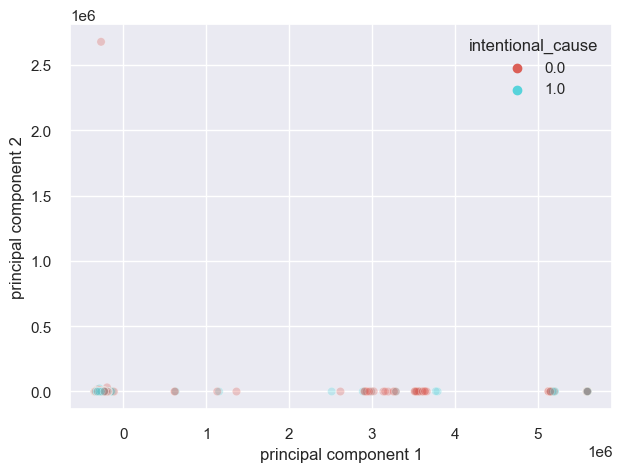

In [303]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="intentional_cause",
    palette=sns.color_palette("hls", 2),
    data=dfPCA_F,
    legend="full",
    alpha=0.3
)

### K-Means

In [319]:
df_kmeans = df_descriptive_modeling.dropna()
cols = ['district','municipality','parish','lat','lon','origin','village_area','vegetation_area','farming_area','dayOfWeekFire','periodOfDay','diffIntAlert','diffExcAlert','avg_temperature','max_temperature']
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

df_kmeans = df_kmeans[cols]
kmeans = KMeans(n_clusters= 6)
model = kmeans.fit(df_kmeans)
df_kmeans['clusters'] = kmeans.labels_
cols.extend(['clusters'])

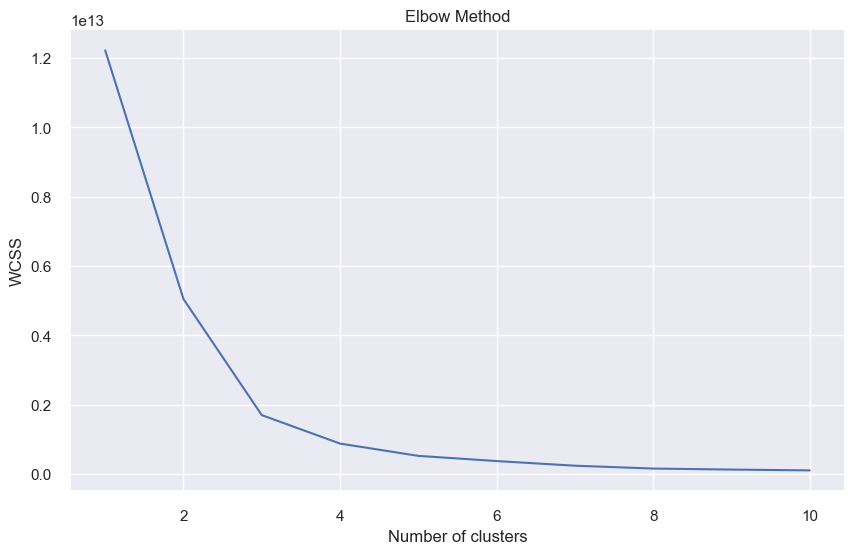

In [320]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_kmeans)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [321]:
kmeans = KMeans(n_clusters= 6)
model = kmeans.fit(df_kmeans)
df_kmeans['clusters'] = kmeans.labels_
cols.extend(['clusters'])

kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")

print("Optimal number of clusters:", kl.elbow)

Optimal number of clusters: 3


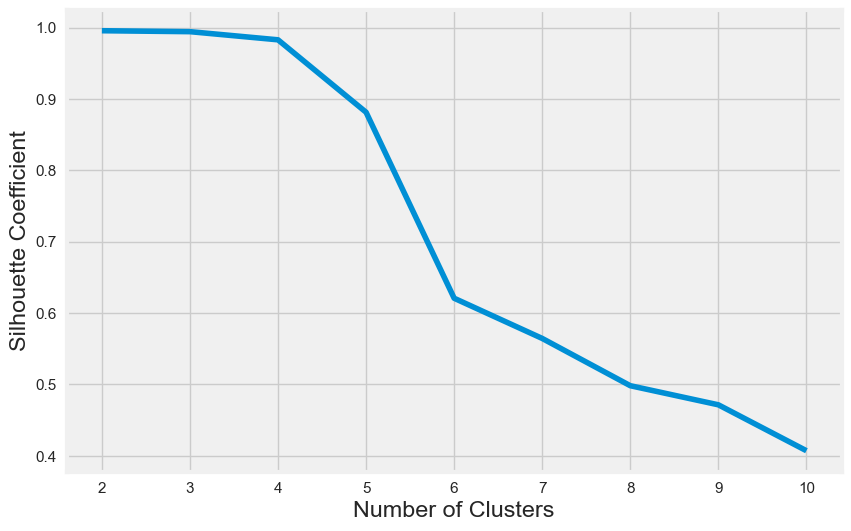

In [322]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_kmeans)
    score = silhouette_score(df_kmeans, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.figure(figsize=(10, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11)) 
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

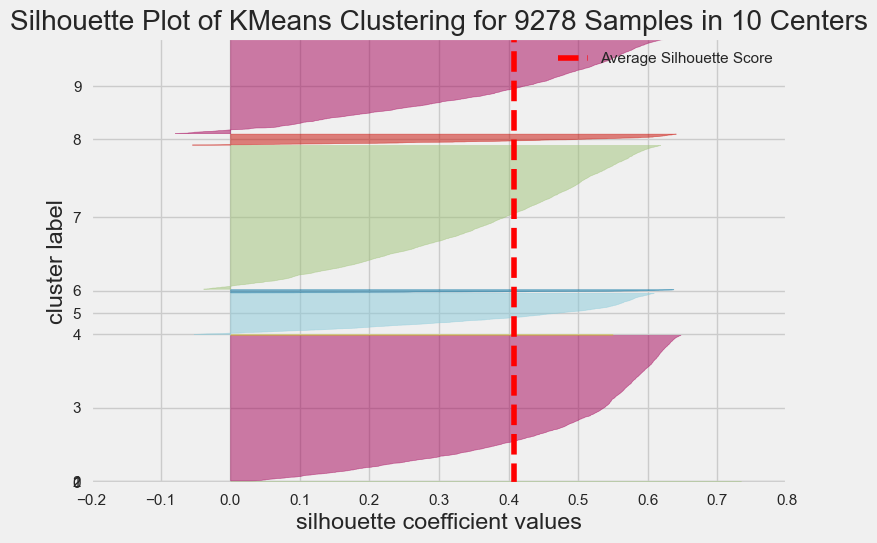

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 9278 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [323]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_kmeans)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure